In [1]:
import os
import json
import sys

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter

sys.path.insert(1,'../optimization/')
from plant_optimization.notebook_tools import *

In [2]:
europe_grid = gpd.read_file('../../data/Countries_WGS84/processed/Europe_Evaluation_Grid.shp')
europe_grid.rename(columns={'grid_lat':'lat','grid_lon':'lon'},inplace=True)
europe_grid['sea_node'] = europe_grid.sea_node.astype(bool)
europe_borders = gpd.read_file('../../data/Countries_WGS84/processed/Europe_WGS84.shp')

EU_EFTA = europe_grid.country.unique()

results_path = os.path.join('../../results/plant_optimization/final_results') # Points to the location of the results csv files

specs = pd.read_excel('../../data/plant_assumptions.xlsx',sheet_name='data',index_col=0)
specs_names = specs.index

lc_path = '../../results/land_availability/CORINE'
sea_area_path = '../../results/land_availability/sea_area'
land_data = pd.DataFrame()
sea_data = pd.DataFrame()
for country in EU_EFTA:
    country_land_data = pd.read_csv(f'{lc_path}/{country}.csv')
    country_land_data['country'] = country

    land_data = land_data.append(country_land_data)
    try:
        sea_data = sea_data.append(pd.read_csv(f'{sea_area_path}/{country}.csv'))
    except FileNotFoundError:
        continue
land_data['sea_node'] = False
sea_data['sea_node'] = True

# Correct an error in which the Norway points are given NaN for the country name
land_data.loc[land_data.country.isna(),'country'] = 'Norway'
sea_data.loc[sea_data.country.isna(),'country'] = 'Norway'
sea_data.rename(columns={'avail_area_sqkm':'0'},inplace=True)
lc_data = pd.concat([land_data,sea_data]).sort_values(['country','lat','lon']).reset_index(drop=True)
# lc_data.crs = gpd.GeoDataFrame(lc_data,crs=europe_grid.crs)

corine_code = pd.read_excel('../../data/CORINE_legend.xlsx',usecols=[0,7])
corine_code = corine_code.rename(columns={'GRID_CODE':'code','LABEL3':'name'}).dropna()

results = {}
for year in [2020,2030,2040,2050]:
    df = pd.read_csv(os.path.join(results_path,f'{year}.csv'))
    df.drop(columns=['geometry'],inplace=True)
    gdf = gpd.GeoDataFrame(df.merge(europe_grid,on=['lat','lon','country','sea_node'],how='left'))

    spacing = gdf['sea_node'].apply(lambda x: {True:specs.at['wind_turbine_spacing_offshore',f'value_2020'],False:specs.at['wind_turbine_spacing_onshore',f'value_2020']}[x])
    gdf['turbine_area_sqkm'] = (gdf.rotor_diameter*spacing)**2*df.wind_turbines/1e6
    gdf['pv_area_sqkm'] = gdf.PV_capacity_MW*1e3/specs.at['PV_peak_per_area','value_2020']
    gdf['plant_area_sqkm'] = gdf['turbine_area_sqkm'] + gdf['pv_area_sqkm']

    results[year] = gdf

In [3]:
def calculate_production_potential(gdf,land_cover_types, remove_offshore_duplicates=True):
    if remove_offshore_duplicates:
        temp = gdf.copy()
        temp = temp.sort_values('shore_dist_x', ascending=True)
        drop_idxs = temp.loc[(temp.duplicated(subset=['lat','lon','shore_designation'], keep='first')) & (temp.shore_designation=='offshore')].index
        gdf = temp.drop(drop_idxs)
    land_cover_types = [str(int(x)) for x in land_cover_types]

    combined = gdf.merge(lc_data,on=['lat','lon','country','sea_node'],how='left')
    combined['avail_area_sqkm'] = combined[land_cover_types].sum(axis=1)
    combined = gpd.GeoDataFrame(combined, crs=gdf.crs)

    combined['plants'] = combined.avail_area_sqkm/combined.plant_area_sqkm
    combined['production_GWh'] = combined.plants * specs.at['required_fuel',f'value_2020']
    combined['production_liters'] = combined.production_GWh*3.6e12/specs.at['kerosene_LHV',f'value_2020']/0.8
    return combined

# Plot cost curve

IATA average jet fuel price for 2021: \$77.6/bbl [source](https://www.iata.org/en/publications/economics/fuel-monitor/)
<br> Average exchange rate 2021: 1.183 USD = 1 EUR [source](https://www.exchangerates.org.uk/EUR-USD-spot-exchange-rates-history-2021.html)
<br> IATA average jet fuel price for 2019: \$79.6/bbl [source](https://iata.org.xy2401.com/publications/economics/fuel-monitor/Pages/index.aspx.html)
<br> Average exchange rate 2019: 1.1199 USD = 1 EUR [source](https://www.exchangerates.org.uk/EUR-USD-spot-exchange-rates-history-2019.html)
<br> 1 US bbl oil = 158.99 L

In [4]:
exchange_rate_2019 = 1.1199 #USD to EUR
exchange_rate_2021 = 1.18 #USD to EUR
exchange_rate_2022 = 1.13 #USD to EUR
bbl_to_liter = 158.99 #US bbl oil to litres
kersone_carbon_intensity = 3.9 # tons CO2 per ton of fuel
ptl_ghg_reduction_factor = 0.88 # expected % GHG reduction of PtL produced from solar/wind power plants

EU32_fuel_demand_kg = 62e9 # 60 Mt jet fuel
kerosene_density = .8 #kg/l
EU32_fuel_demand_liters = EU32_fuel_demand_kg/kerosene_density
fossil_kerosene_price = 0.4 # EUR/l

def calculate_cost_curve(df,max_lcof = 5):
    cost_curve = df.loc[df.LCOF_liter<=max_lcof].sort_values('LCOF_liter').reset_index()
    cost_curve['production_liters_cumsum'] = cost_curve.production_liters.cumsum()
    return cost_curve

In [5]:
plt.style.reload_library()
plt.style.use('EuroSAFs_pub')
%matplotlib inline

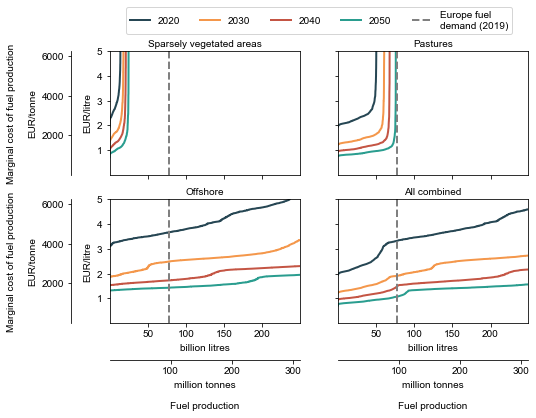

In [21]:
fig,axes = plt.subplots(nrows=2, ncols=2,figsize=(7.5,5))
axes = axes.reshape(1,-1)[0]
max_lcof=5

y_min = 1e-6 #0
y_max = max_lcof
x_min = 1e-6 #cost_curve.production_liters_cumsum.min()/1e9 # billion litres
x_max = 249 #325 # billion litres


scenarios = [[32],[18],[0],[0,18,32]]
titles = [
    'Sparsely vegetated areas',
    'Pastures',
    'Offshore',
    'All combined'
]

for j,(land_types,title) in enumerate(zip(scenarios,titles)):
    for i,year in enumerate([2020,2030,2040,2050]):
        production_potential = calculate_production_potential(results[year],land_types)
        cost_curve = calculate_cost_curve(production_potential)

        axes[j].plot(cost_curve.production_liters_cumsum/1e9,cost_curve.LCOF_liter, label=year)
    
    
       
    axes[j].axvline(x=EU32_fuel_demand_liters/1e9, color='grey', linestyle='--', label='Europe fuel\ndemand (2019)')

    axes[j].set_title(title,pad=5)
    axes[j].set_ylim(y_min,y_max)
    axes[j].set_xlim(x_min,x_max)

    
    if j%2 == 0:
        axes[j].set_ylabel('EUR/litre', labelpad=5)
    
        yax2 = axes[j].secondary_yaxis(-0.2, functions=(lambda y: y/kerosene_density*1e3, lambda y: y*kerosene_density/1e3))
        yax2.set_ylabel('Marginal cost of fuel production\n\nEUR/tonne', labelpad=5)
        
    else:
        axes[j].tick_params(labelleft=False)  
        
    if j>1:
        axes[j].set_xlabel('billion litres', labelpad=5)

        xax2 = axes[j].secondary_xaxis(-0.3, functions=(lambda x: x/kerosene_density, lambda x: x*kerosene_density))
        xax2.set_xlabel('million tonnes\n\nFuel production', labelpad=5)
    else:
        axes[j].tick_params(labelbottom=False) 

axes[0].legend(ncol=5, bbox_to_anchor=(1.1, 1.4), loc='upper center')
plt.savefig('../../gfx/pan-european_cost_curve_grid.png', bbox_inches='tight',dpi=400);

In [7]:
print('By 2030, the following countries can produce at least a billion litres of fuel at costs lower than 1.5 EUR/litre:')
for j, country in enumerate(EU_EFTA):
    df = results[2030].copy()
    df = df.loc[df.country==country]
    production_potential = calculate_production_potential(df,[0,18,32])
    cost_curve = calculate_cost_curve(production_potential)
    fuel_vol = cost_curve.loc[(cost_curve.LCOF_liter<=1.5),'production_liters'].sum()
    if fuel_vol > 1e9:
        print(country)

By 2030, the following countries can produce at least a billion litres of fuel at costs lower than 1.5 EUR/litre:
France
Germany
Iceland
Ireland
Netherlands
Poland
United_Kingdom


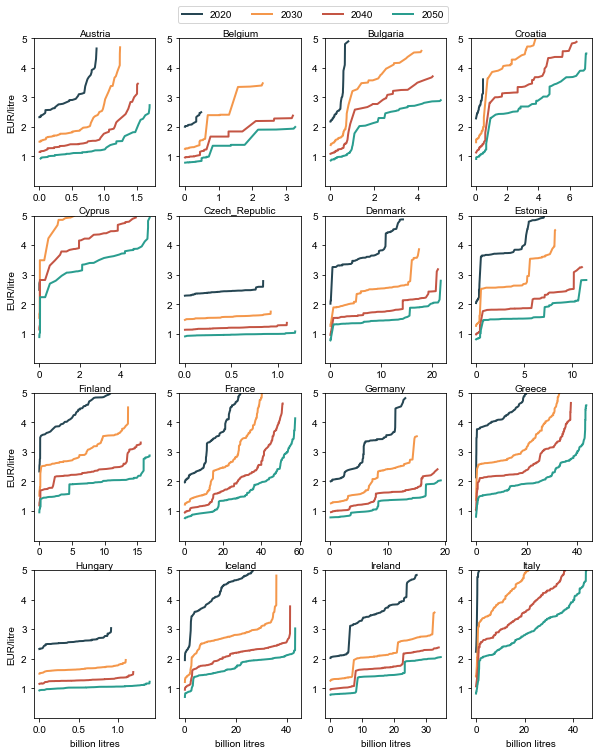

In [8]:
fig,axes = plt.subplots(nrows=4, ncols=4,figsize=(10,12.5))
axes = axes.reshape(1,-1)[0]
max_lcof=5

y_min = 1e-6 #0
y_max = max_lcof
x_min = 1e-6 #cost_curve.production_liters_cumsum.min()/1e9 # billion litres
x_max = 249 #325 # billion litres


scenarios = [[32],[18],[0],[0,18,32]]

for j, country in enumerate(EU_EFTA[:16]):
    for i,year in enumerate([2020,2030,2040,2050]):
        df = results[year].copy()
        df = df.loc[df.country==country]
        production_potential = calculate_production_potential(df,[0,18,32])
        cost_curve = calculate_cost_curve(production_potential)

        axes[j].plot(cost_curve.production_liters_cumsum/1e9,cost_curve.LCOF_liter, label=year)

    axes[j].set_title(country,pad=2)
    axes[j].set_ylim(y_min,y_max)
    if j%4==0:
        axes[j].set_ylabel('EUR/litre', labelpad=5)
    if j>11:
        axes[j].set_xlabel('billion litres', labelpad=5)
    
# fig.suptitle('Domestic SAF cost curves',x=0.5,y=1.);
axes[1].legend(ncol=5, bbox_to_anchor=(1.1, 1.25), loc='upper center')
# plt.tight_layout()
# plt.savefig('../../gfx/country_cost_curves_1.png', bbox_inches='tight',dpi=400);

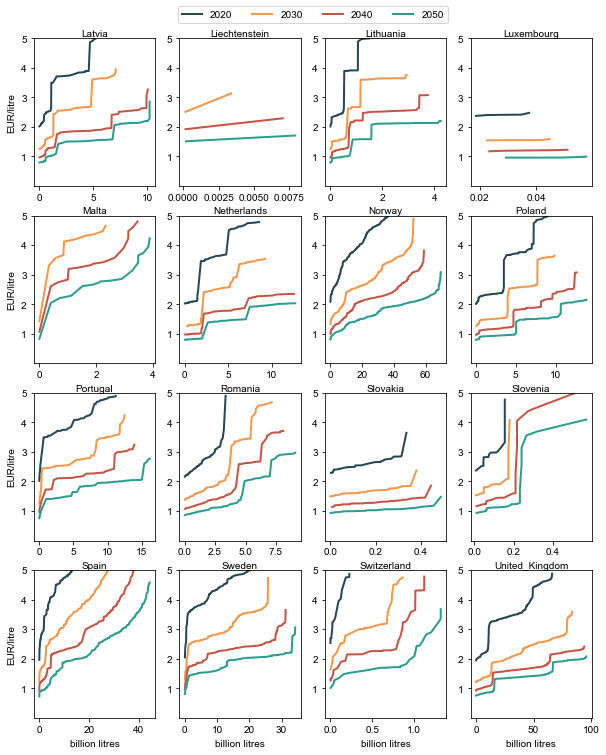

In [9]:
fig,axes = plt.subplots(nrows=4, ncols=4,figsize=(10,12.5))
axes = axes.reshape(1,-1)[0]
max_lcof=5

y_min = 1e-6 #0
y_max = max_lcof
x_min = 1e-6 #cost_curve.production_liters_cumsum.min()/1e9 # billion litres
x_max = 249 #325 # billion litres


scenarios = [[32],[18],[0],[0,18,32]]

for j, country in enumerate(EU_EFTA[16:]):
    for i,year in enumerate([2020,2030,2040,2050]):
        df = results[year].copy()
        df = df.loc[df.country==country]
        production_potential = calculate_production_potential(df,[0,18,32])
        cost_curve = calculate_cost_curve(production_potential)

        axes[j].plot(cost_curve.production_liters_cumsum/1e9,cost_curve.LCOF_liter, label=year)

    axes[j].set_title(country,pad=2)
    axes[j].set_ylim(y_min,y_max)
    if j%4==0:
        axes[j].set_ylabel('EUR/litre', labelpad=5)
    if j>11:
        axes[j].set_xlabel('billion litres', labelpad=5)
    
# fig.suptitle('Domestic SAF cost curves',x=0.5,y=1.);
axes[1].legend(ncol=5, bbox_to_anchor=(1.1, 1.25), loc='upper center')
# plt.tight_layout()
# plt.savefig('../../gfx/country_cost_curves_2.png', bbox_inches='tight',dpi=400);

# Export data

In [10]:
scenarios = [[32],[18],[0],[0,18,32]]
titles = [
    'Sparsely vegetated areas',
    'Pastures',
    'Offshore',
    'All combined'
]

for j,(land_types,title) in enumerate(zip(scenarios,titles)):
    cost_curves_combined = pd.DataFrame()
    for i,year in enumerate([2020,2030,2040,2050]):
        production_potential = calculate_production_potential(results[year],land_types)
        cost_curve = calculate_cost_curve(production_potential, max_lcof=1e6)
        cost_curve = cost_curve[['LCOF_liter','production_liters','production_liters_cumsum']]
        cost_curve.rename(columns={x:x+f'_{year}' for x in cost_curve.columns},inplace=True)
        cost_curves_combined = pd.concat([cost_curves_combined,cost_curve],axis=1)
    cost_curves_combined.to_csv(os.path.join('..','..','results','plant_optimization','final_results','cost_curves',f'{title} cost curve.csv'))

# Blending quota costs & green premiums

Assuming 1.5% fuel efficiency improvement p.a. to 2050...

Commission quota premiums: {2030: '0.3%', 2040: '2.3%', 2050: '5.2%'}
Parliament quota premiums: {2030: '1.0%', 2040: '3.9%', 2050: '10.7%'}


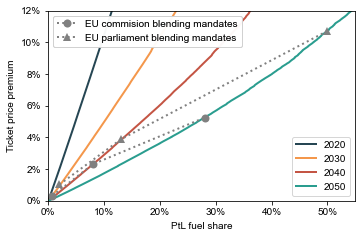

In [22]:
commission_quotas = [0.7, 8, 28] #2030,2040,2050
commission_quota_premiums = []
parliament_quotas = [2, 13, 50] #2030,2040,2050
parliament_quota_premiums = []

fig,ax = plt.subplots(figsize=(5.5,3.5))

for i,year in enumerate([2020,2030,2040,2050]):
    production_potential = calculate_production_potential(results[year],[0,18,32])
    cost_curve = calculate_cost_curve(production_potential)
    cost_curve['fuel_share'] = cost_curve['production_liters_cumsum']/EU32_fuel_demand_liters
    cost_curve['LCOF_blend'] = cost_curve['fuel_share']*cost_curve['LCOF_liter'] + (1-cost_curve['fuel_share'])*fossil_kerosene_price
    
    # This assumes annual fuel efficiency improvement of 1.5%
    cost_curve['ticket_premium'] = (((0.985**(year-2020))*cost_curve['LCOF_blend'] + 3*fossil_kerosene_price)/((0.985**(year-2020))*fossil_kerosene_price + 3*fossil_kerosene_price) - 1)*100
    
    ax.plot(cost_curve['fuel_share']*100,cost_curve['ticket_premium'], label=year)
    if i>0:
        commission_quota_premiums.append(cost_curve.iloc[abs(cost_curve['fuel_share']*100 - commission_quotas[i-1]).argmin()]['ticket_premium'])
        parliament_quota_premiums.append(cost_curve.iloc[abs(cost_curve['fuel_share']*100 - parliament_quotas[i-1]).argmin()]['ticket_premium'])


ax.plot(commission_quotas, commission_quota_premiums, marker='o', c='grey', alpha=1, markeredgewidth=0.0, markersize=8, linestyle=':', label='EU commision blending mandates')
ax.plot(parliament_quotas, parliament_quota_premiums, marker='^', c='grey', alpha=1, markeredgewidth=0.0, markersize=8, linestyle=':', label='EU parliament blending mandates')

ax.set_ylim(0,12)
ax.set_xlim(0,55)

ax.set_ylabel('Ticket price premium', labelpad=5)
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}%'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}%'))

ax.set_xlabel('PtL fuel share', labelpad=5)


lines = ax.get_lines()
legend1 = ax.legend([lines[i] for i in [0,1,2,3]], [2020,2030,2040,2050], loc='lower right')
legend2 = ax.legend([lines[i] for i in [4,5]], ['EU commision blending mandates','EU parliament blending mandates'], loc='upper left')
ax.add_artist(legend1)
ax.add_artist(legend2)

plt.savefig('../../gfx/ticket_premium_curve.png', bbox_inches='tight',dpi=400);
print('Commission quota premiums:',{year:f'{round(x,1)}%' for year,x in zip([2030,2040,2050],commission_quota_premiums)})
print('Parliament quota premiums:',{year:f'{round(x,1)}%' for year,x in zip([2030,2040,2050],parliament_quota_premiums)})

In [54]:
quota_summary_df = pd.DataFrame(index=[
    'Commission quota marginal LCOF (EUR/l)',
    'Parliament quota marginal LCOF (EUR/l)',
    'Commission quota average LCOF (EUR/l)',
    'Parliament quota average LCOF (EUR/l)',
    'Commission quota wind capacity (GW)',
    'Parliament quota wind capacity (GW)',
    'Commission quota PV capacity (GW)',
    'Parliament quota PV capacity (GW)',
    'Lowest-cost production site LCOF (EUR/l)',
    ], columns=[2030,2040,2050])
commission_quota_marginal_lcofs = {}
commission_quota_average_lcofs  = {}
commission_quota_wind_capacity  = {}
commission_quota_PV_capacity  = {}
parliament_quota_marginal_lcofs = {}
parliament_quota_average_lcofs  = {}
parliament_quota_wind_capacity  = {}
parliament_quota_PV_capacity  = {}
minimum_lcof = {}
for i,year in enumerate(quota_summary_df.columns):
    production_potential = calculate_production_potential(results[year],[0,18,32])
    quota_summary_df.loc['Lowest-cost production site LCOF (EUR/l)',year] = round(production_potential['LCOF_liter'].min(),2)
    cost_curve = calculate_cost_curve(production_potential)
    cost_curve['fuel_share'] = cost_curve['production_liters_cumsum']/EU32_fuel_demand_liters*100
    
    quota_summary_df.loc['Commission quota marginal LCOF (EUR/l)',year] = round(cost_curve.iloc[abs(cost_curve['fuel_share'] - commission_quotas[i]).argmin()]['LCOF_liter'],2)
    quota_summary_df.loc['Parliament quota marginal LCOF (EUR/l)',year] = round(cost_curve.iloc[abs(cost_curve['fuel_share'] - parliament_quotas[i]).argmin()]['LCOF_liter'],2)

    df = cost_curve.loc[cost_curve['fuel_share']<=commission_quotas[i]]
    quota_summary_df.loc['Commission quota average LCOF (EUR/l)',year] = round((df['LCOF_liter']*df['production_liters']).sum()/df['production_liters'].sum(),2)
    quota_summary_df.loc['Commission quota wind capacity (GW)',year] = round(sum(df['wind_capacity_MW']*df['plants'])/1e3,2)
    quota_summary_df.loc['Commission quota PV capacity (GW)',year] = round(sum(df['PV_capacity_MW']*df['plants'])/1e3,2)
    
    df = cost_curve.loc[cost_curve['fuel_share']<=parliament_quotas[i]]
    quota_summary_df.loc['Parliament quota average LCOF (EUR/l)',year] = round((df['LCOF_liter']*df['production_liters']).sum()/df['production_liters'].sum(),2)
    quota_summary_df.loc['Parliament quota wind capacity (GW)',year] = round(sum(df['wind_capacity_MW']*df['plants'])/1e3,2)
    quota_summary_df.loc['Parliament quota PV capacity (GW)',year] = round(sum(df['PV_capacity_MW']*df['plants'])/1e3,2)
    
quota_summary_df

,2030,2040,2050
Commission quota marginal LCOF (EUR/l),1.23,0.98,0.83
Parliament quota marginal LCOF (EUR/l),1.25,1.0,0.89
Commission quota average LCOF (EUR/l),1.22,0.97,0.8
Parliament quota average LCOF (EUR/l),1.23,0.98,0.83
Commission quota wind capacity (GW),5.39,61.7,202.29
Parliament quota wind capacity (GW),14.74,100.37,357.39
Commission quota PV capacity (GW),5.18,53.65,192.57
Parliament quota PV capacity (GW),14.44,87.07,387.96
Lowest-cost production site LCOF (EUR/l),1.21,0.93,0.71


In [27]:
print('2050 PtL market under Commission mandate:', quota_summary_df.loc['Commission quota average LCOF (EUR/l)',2050]*EU32_fuel_demand_liters*commission_quotas[2]/100/1e9, 'billion EUR')
print('2050 PtL market under Parliament mandate:', quota_summary_df.loc['Parliament quota average LCOF (EUR/l)',2050]*EU32_fuel_demand_liters*parliament_quotas[2]/100/1e9, 'billion EUR')

2050 PtL market under Commission mandate: 17.36 billion EUR
2050 PtL market under Parliament mandate: 32.1625 billion EUR


In [53]:
premium_df = quota_summary_df.loc[[
    'Commission quota marginal LCOF (EUR/l)',
    'Parliament quota marginal LCOF (EUR/l)',
    'Commission quota average LCOF (EUR/l)',
    'Parliament quota average LCOF (EUR/l)',
    'Lowest-cost production site LCOF (EUR/l)']].copy()
premium_df.index = [x.replace('LCOF (EUR/l)','GHG abatement cost (EUR/tCO2)') for x in premium_df.index]

premium_per_ton = (premium_df - 0.4)/(kerosene_density/1e3) # EUR
co2_savings_per_ton_ptl = kersone_carbon_intensity*ptl_ghg_reduction_factor # tonnes
ghg_abatement_cost = premium_per_ton/co2_savings_per_ton_ptl
premium_df = ghg_abatement_cost.astype(float).round(3)
premium_df

,2030,2040,2050
Commission quota marginal GHG abatement cost (EUR/tCO2),302.302,211.247,156.614
Parliament quota marginal GHG abatement cost (EUR/tCO2),309.586,218.531,178.467
Commission quota average GHG abatement cost (EUR/tCO2),298.660,207.605,145.688
Parliament quota average GHG abatement cost (EUR/tCO2),302.302,211.247,156.614
Lowest-cost production site GHG abatement cost (EUR/tCO2),295.017,193.036,112.908


# Auxiliary figures

Commission quota premiums: {2030: '0.2%', 2040: '1.6%', 2050: '3.4%'}
Parliament quota premiums: {2030: '0.6%', 2040: '2.6%', 2050: '7.0%'}


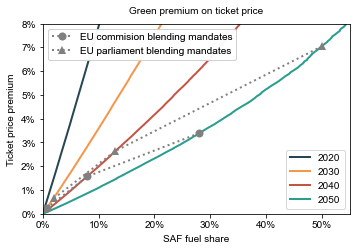

In [29]:
commission_quotas = [0.7, 8, 28] #2030,2040,2050
commission_quota_premiums = []
parliament_quotas = [2, 13, 50] #2030,2040,2050
parliament_quota_premiums = []

fig,ax = plt.subplots(figsize=(5.5,3.5))

for i,year in enumerate([2020,2030,2040,2050]):
    production_potential = calculate_production_potential(results[year],[0,18,32])
    cost_curve = calculate_cost_curve(production_potential)
    cost_curve['fuel_share'] = cost_curve['production_liters_cumsum']/EU32_fuel_demand_liters*100
    cost_curve['green_premium_fuel'] = ((cost_curve['fuel_share']/100*cost_curve['LCOF_liter'] + (1-cost_curve['fuel_share']/100)*fossil_kerosene_price)/fossil_kerosene_price-1)*100
    
    # This assumes annual fuel efficiency improvement of 1%
    ticket_price_factor = 1/4*0.99**(year-2020)
    cost_curve['green_premium_ticket'] = cost_curve['green_premium_fuel']*ticket_price_factor
    
    ax.plot(cost_curve['fuel_share'],cost_curve['green_premium_ticket'], label=year)
    if i>0:
        commission_quota_premiums.append(cost_curve.iloc[abs(cost_curve['fuel_share'] - commission_quotas[i-1]).argmin()]['green_premium_ticket'])
        parliament_quota_premiums.append(cost_curve.iloc[abs(cost_curve['fuel_share'] - parliament_quotas[i-1]).argmin()]['green_premium_ticket'])


ax.plot(commission_quotas, commission_quota_premiums, marker='o', c='grey', alpha=1, markeredgewidth=0.0, markersize=8, linestyle=':', label='EU commision blending mandates')
ax.plot(parliament_quotas, parliament_quota_premiums, marker='^', c='grey', alpha=1, markeredgewidth=0.0, markersize=8, linestyle=':', label='EU parliament blending mandates')

ax.set_ylim(0,8)
ax.set_xlim(0,55)

ax.set_ylabel('Ticket price premium', labelpad=5)
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}%'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}%'))

ax.set_xlabel('PtL fuel share', labelpad=5)


ax.set_title('Green premium on ticket price', pad=10);
lines = ax.get_lines()
legend1 = ax.legend([lines[i] for i in [0,1,2,3]], [2020,2030,2040,2050], loc='lower right')
legend2 = ax.legend([lines[i] for i in [4,5]], ['EU commision blending mandates','EU parliament blending mandates'], loc='upper left')
ax.add_artist(legend1)
ax.add_artist(legend2)

plt.savefig('../../gfx/green_premium_curve.png', bbox_inches='tight',dpi=400);
print('Commission quota premiums:',{year:f'{round(x,1)}%' for year,x in zip([2030,2040,2050],commission_quota_premiums)})
print('Parliament quota premiums:',{year:f'{round(x,1)}%' for year,x in zip([2030,2040,2050],parliament_quota_premiums)})

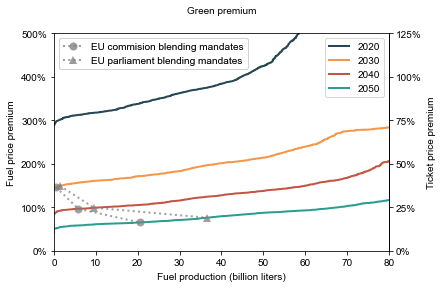

In [135]:
commission_quotas = [0.7, 8, 28]
commission_quota_volumes = []
commission_quota_premiums = []
parliament_quotas = [2, 13, 50]
parliament_quota_volumes = []
parliament_quota_premiums = []

fig,ax = plt.subplots(figsize=(6,4))

for i,year in enumerate([2020,2030,2040,2050]):
    production_potential = calculate_production_potential(results[year],[0,18,32])
    cost_curve = calculate_cost_curve(production_potential)
    cost_curve['green_premium_fuel'] = (cost_curve['LCOF_liter']/fossil_kerosene_price-1)*100
    
    ax.plot(cost_curve['production_liters_cumsum']/1e9,cost_curve['green_premium_fuel'], label=year)
    if i>0:
        commission_idx = abs(cost_curve['production_liters_cumsum'] - commission_quotas[i-1]/100*EU32_fuel_demand_liters).argmin()
        commission_quota_volumes.append(cost_curve.iloc[commission_idx]['production_liters_cumsum']/1e9)
        commission_quota_premiums.append(cost_curve.iloc[commission_idx]['green_premium_fuel'])
        parliament_idx = abs(cost_curve['production_liters_cumsum'] - parliament_quotas[i-1]/100*EU32_fuel_demand_liters).argmin()
        parliament_quota_volumes.append(cost_curve.iloc[parliament_idx]['production_liters_cumsum']/1e9)
        parliament_quota_premiums.append(cost_curve.iloc[parliament_idx]['green_premium_fuel'])

ax.plot(commission_quota_volumes, commission_quota_premiums, marker='o', c='grey', alpha=0.75, markeredgewidth=0.0, markersize=8, linestyle=':', label='EU commision blending mandates')
ax.plot(parliament_quota_volumes, parliament_quota_premiums, marker='^', c='grey', alpha=0.75, markeredgewidth=0.0, markersize=8, linestyle=':', label='EU parliament blending mandates')

ax.set_ylim(0,500)
ax.set_xlim(0,80)

ax.set_ylabel('Fuel price premium', labelpad=5)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}%'))

yax2 = ax.secondary_yaxis('right', functions=(lambda y: y/4, lambda y: y*4))
yax2.set_ylabel('Ticket price premium', labelpad=5)
yax2.set_yticks([x/4 for x in ax.get_yticks()]) # Assume fuel costs are 1/4 of the ticket price
yax2.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}%'))

ax.set_xlabel('Fuel production (billion litres)', labelpad=5)


ax.set_title('Green premium');
lines = ax.get_lines()
legend1 = ax.legend([lines[i] for i in [0,1,2,3]], [2020,2030,2040,2050], loc='upper right')
legend2 = ax.legend([lines[i] for i in [4,5]], ['EU commision blending mandates','EU parliament blending mandates'], loc='upper left')
ax.add_artist(legend1)
ax.add_artist(legend2)


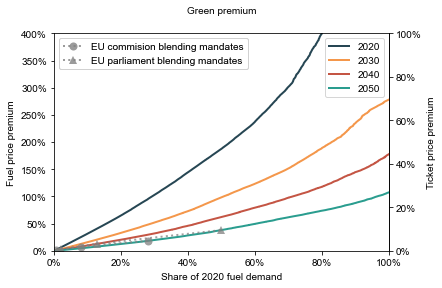

In [112]:
commission_quotas = [0.7, 8, 28]
commission_quota_premiums = []
parliament_quotas = [2, 13, 50]
parliament_quota_premiums = []

fig,ax = plt.subplots(figsize=(6,4))
max_lcof=5

y_min = 1e-6 #0
y_max = max_lcof
x_min = 0
x_max = 249 #325 # billion litres


scenarios = [[32],[18],[0],[0,18,32]]
titles = [
    'Sparsely vegetated areas',
    'Pastures',
    'Offshore',
    'All combined'
]

for i,year in enumerate([2020,2030,2040,2050]):
    production_potential = calculate_production_potential(results[year],[0,18,32])
    cost_curve = calculate_cost_curve(production_potential)
    cost_curve['2020_fuel_share'] = cost_curve['production_liters_cumsum']/EU32_fuel_demand_liters*100
    cost_curve['green_premium_fuel'] = ((cost_curve['2020_fuel_share']*cost_curve['LCOF_liter']+(1-cost_curve['2020_fuel_share'])*fossil_kerosene_price)-fossil_kerosene_price)/fossil_kerosene_price
#     cost_curve['green_premium_ticket'] = cost_curve['green_premium_fuel']/4
    
    ax.plot(cost_curve['2020_fuel_share'],cost_curve['green_premium_fuel'], label=year)
    if i>0:
        commission_quota_premiums.append(cost_curve.iloc[abs(cost_curve['2020_fuel_share'] - commission_quotas[i-1]).argmin()]['green_premium_fuel'])
        parliament_quota_premiums.append(cost_curve.iloc[abs(cost_curve['2020_fuel_share'] - parliament_quotas[i-1]).argmin()]['green_premium_fuel'])


ax.plot(commission_quotas, commission_quota_premiums, marker='o', c='grey', alpha=0.75, markeredgewidth=0.0, markersize=8, linestyle=':', label='EU commision blending mandates')
ax.plot(parliament_quotas, parliament_quota_premiums, marker='^', c='grey', alpha=0.75, markeredgewidth=0.0, markersize=8, linestyle=':', label='EU parliament blending mandates')

ax.set_ylim(0,400)
ax.set_xlim(0,100)


ax.set_ylabel('Fuel price premium', labelpad=5)
ax.xaxis.set_major_formatter(StrMethodFormatter('{x:.0f}%'))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}%'))


yax2 = ax.secondary_yaxis('right', functions=(lambda y: y/4, lambda y: y*4))
yax2.set_ylabel('Ticket price premium', labelpad=5)

yax2.yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}%'))

ax.set_xlabel('Share of 2020 fuel demand', labelpad=5)


ax.set_title('Green premium');
lines = ax.get_lines()
legend1 = ax.legend([lines[i] for i in [0,1,2,3]], [2020,2030,2040,2050], loc='upper right')
legend2 = ax.legend([lines[i] for i in [4,5]], ['EU commision blending mandates','EU parliament blending mandates'], loc='upper left')
ax.add_artist(legend1)
ax.add_artist(legend2)

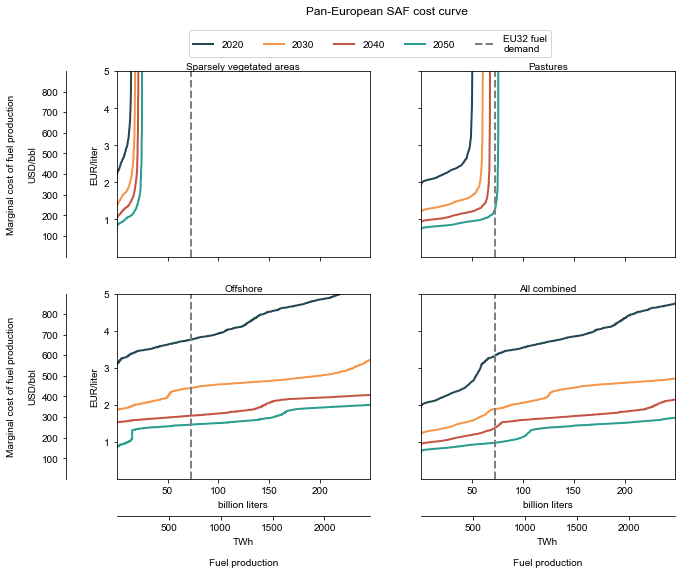

In [6]:
fig,axes = plt.subplots(nrows=2, ncols=2,figsize=(10,7.5))
axes = axes.reshape(1,-1)[0]
max_lcof=5

y_min = 1e-6 #0
y_max = max_lcof
x_min = 1e-6 #cost_curve.production_liters_cumsum.min()/1e9 # billion litres
x_max = 249 #325 # billion litres


scenarios = [[32],[18],[0],[0,18,32]]
titles = [
    'Sparsely vegetated areas',
    'Pastures',
    'Offshore',
    'All combined'
]

for j,(land_types,title) in enumerate(zip(scenarios,titles)):
    for i,year in enumerate([2020,2030,2040,2050]):
        production_potential = calculate_production_potential(results[year],land_types)
        cost_curve = calculate_cost_curve(production_potential)

        axes[j].plot(cost_curve.production_liters_cumsum/1e9,cost_curve.LCOF_liter, label=year)
    
    
       
    axes[j].axvline(x=EU32_fuel_demand_liters/1e9, color='grey', linestyle='--', label='Europe fuel\ndemand')

    axes[j].set_title(title,pad=2)
    axes[j].set_ylim(y_min,y_max)
    axes[j].set_xlim(x_min,x_max)

    
    if j%2 == 0:
        axes[j].set_ylabel('EUR/litre', labelpad=5)
    
        yax2 = axes[j].secondary_yaxis(-0.2, functions=(lambda y: y*exchange_rate_2022*bbl_to_liter, lambda y: y/exchange_rate_2022/bbl_to_liter))
        yax2.set_ylabel('Marginal cost of fuel production\n\nUSD/bbl', labelpad=5)
        
    else:
        axes[j].tick_params(labelleft=False)  
        
    if j>1:
        axes[j].set_xlabel('billion litres', labelpad=5)

        xax2 = axes[j].secondary_xaxis(-0.2, functions=(lambda x: x*0.8*specs.at['kerosene_LHV','value_2020']/3.6e6, lambda x: x/0.8/specs.at['kerosene_LHV','value_2020']*3.6e6))
        xax2.set_xlabel('TWh\n\nFuel production', labelpad=5)
    else:
        axes[j].tick_params(labelbottom=False) 

fig.suptitle('Pan-European SAF cost curve',x=0.5,y=1.);
axes[0].legend(ncol=5, bbox_to_anchor=(1, 1.25), loc='upper center')
# plt.savefig('../../gfx/pan-european_cost_curve_grid.png', bbox_inches='tight',dpi=400);

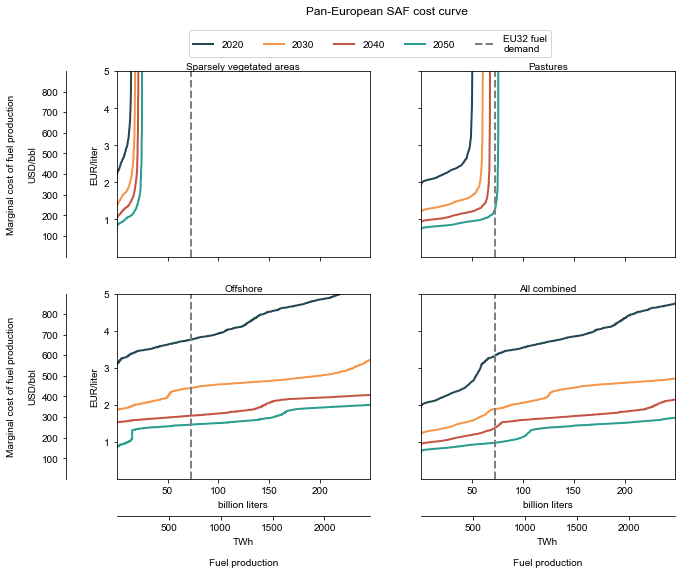

In [6]:
fig,axes = plt.subplots(nrows=2, ncols=2,figsize=(10,7.5))
axes = axes.reshape(1,-1)[0]
max_lcof=5

y_min = 1e-6 #0
y_max = max_lcof
x_min = 1e-6 #cost_curve.production_liters_cumsum.min()/1e9 # billion litres
x_max = 249 #325 # billion litres


scenarios = [[32],[18],[0],[0,18,32]]
titles = [
    'Sparsely vegetated areas',
    'Pastures',
    'Offshore',
    'All combined'
]

for j,(land_types,title) in enumerate(zip(scenarios,titles)):
    for i,year in enumerate([2020,2030,2040,2050]):
        production_potential = calculate_production_potential(results[year],land_types)
        cost_curve = calculate_cost_curve(production_potential)

        axes[j].plot(cost_curve.production_liters_cumsum/1e9,cost_curve.LCOF_liter, label=year)
    
    
       
    axes[j].axvline(x=EU32_fuel_demand_liters/1e9, color='grey', linestyle='--', label='Europe fuel\ndemand')

    axes[j].set_title(title,pad=2)
    axes[j].set_ylim(y_min,y_max)
    axes[j].set_xlim(x_min,x_max)

    
    if j%2 == 0:
        axes[j].set_ylabel('EUR/litre', labelpad=5)
    
        yax2 = axes[j].secondary_yaxis(-0.2, functions=(lambda y: y*exchange_rate_2022*bbl_to_liter, lambda y: y/exchange_rate_2022/bbl_to_liter))
        yax2.set_ylabel('Marginal cost of fuel production\n\nUSD/bbl', labelpad=5)
        
    else:
        axes[j].tick_params(labelleft=False)  
        
    if j>1:
        axes[j].set_xlabel('billion litres', labelpad=5)

        xax2 = axes[j].secondary_xaxis(-0.2, functions=(lambda x: x*0.8*specs.at['kerosene_LHV','value_2020']/3.6e6, lambda x: x/0.8/specs.at['kerosene_LHV','value_2020']*3.6e6))
        xax2.set_xlabel('TWh\n\nFuel production', labelpad=5)
    else:
        axes[j].tick_params(labelbottom=False) 

fig.suptitle('Pan-European SAF cost curve',x=0.5,y=1.);
axes[0].legend(ncol=5, bbox_to_anchor=(1, 1.25), loc='upper center')
# plt.savefig('../../gfx/pan-european_cost_curve_grid.png', bbox_inches='tight',dpi=400);

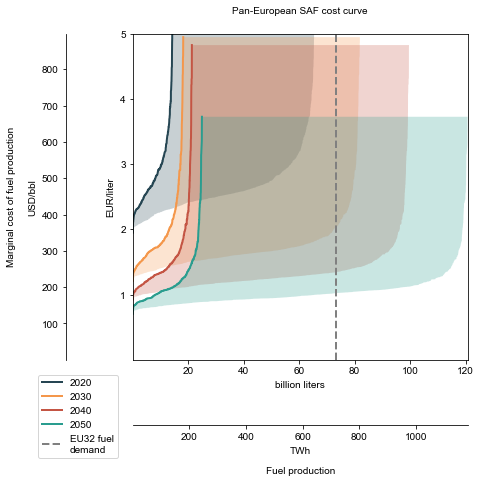

In [8]:
fig,axes = plt.subplots(figsize=(6,6))
max_lcof=5

for i,year in enumerate([2020,2030,2040,2050]):
    production_potential1 = calculate_production_potential(results[year],[32])
    cost_curve1 = calculate_cost_curve(production_potential1)
    
    axes.plot(cost_curve1.production_liters_cumsum/1e9,cost_curve1.LCOF_liter, label=year)
    
    land_production_potential = production_potential1.copy()
    land_production_potential.loc[production_potential1.sea_node,'production_liters'] = 0
    land_cost_curve = calculate_cost_curve(land_production_potential)
    
    production_potential2 = calculate_production_potential(results[year],[13,22,28,29,32])#[x for x in np.arange(1,51)])
    cost_curve2 = calculate_cost_curve(production_potential2)
    
    axes.fill_betweenx(land_cost_curve.LCOF_liter,land_cost_curve.production_liters_cumsum/1e9,cost_curve2.production_liters_cumsum/1e9,alpha=0.25)
    
    
    
axes.axvline(x=EU32_fuel_demand_liters/1e9, color='grey', linestyle='--', label='Europe fuel\ndemand')

y_min = 1e-6 #0
y_max = max_lcof
x_min = 1e-6 #cost_curve.production_liters_cumsum.min()/1e9 # billion litres
x_max = cost_curve2.production_liters_cumsum.max()/1e9 # billion litres

axes.set_ylim(y_min,y_max)
axes.set_ylabel('EUR/litre', labelpad=5)

yax2 = axes.secondary_yaxis(-0.2, functions=(lambda y: y*exchange_rate_2022*bbl_to_liter, lambda y: y/exchange_rate_2022/bbl_to_liter))
yax2.set_ylabel('Marginal cost of fuel production\n\nUSD/bbl', labelpad=5)

axes.set_xlim(x_min,x_max)
axes.set_xlabel('billion litres', labelpad=5)


xax2 = axes.secondary_xaxis(-0.2, functions=(lambda x: x*0.8*specs.at['kerosene_LHV','value_2020']/3.6e6, lambda x: x/0.8/specs.at['kerosene_LHV','value_2020']*3.6e6))

xax2.set_xlabel('TWh\n\nFuel production', labelpad=5)

axes.set_title('Pan-European SAF cost curve');#,pad=75);
axes.legend(ncol=1, bbox_to_anchor=(-0.03, -0.03), loc='upper right')

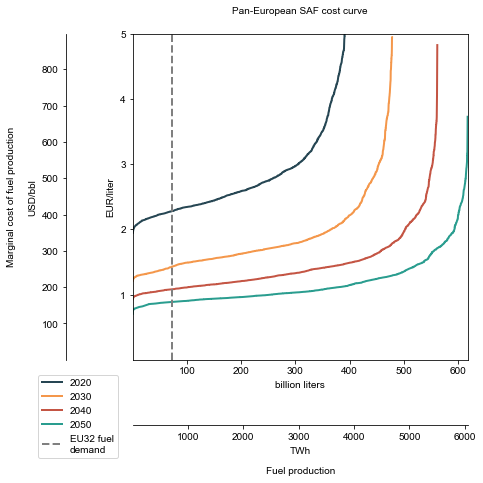

In [9]:
fig,axes = plt.subplots(figsize=(6,6))

for year in [2020,2030,2040,2050]:
    production_potential = calculate_production_potential(results[year],[0,18,32])
    cost_curve = calculate_cost_curve(production_potential)
    axes.plot(cost_curve.production_liters_cumsum/1e9,cost_curve.LCOF_liter, label=year)
    
axes.axvline(x=EU32_fuel_demand_liters/1e9, color='grey', linestyle='--', label='Europe fuel\ndemand')

y_min = 1e-6 #0
y_max = max_lcof
x_min = 1e-6 #cost_curve.production_liters_cumsum.min()/1e9 # billion litres
x_max = cost_curve.production_liters_cumsum.max()/1e9 # billion litres

axes.set_ylim(y_min,y_max)
axes.set_ylabel('EUR/litre', labelpad=5)
yax2 = axes.secondary_yaxis(-0.2, functions=(lambda y: y*exchange_rate_2022*bbl_to_liter, lambda y: y/exchange_rate_2022/bbl_to_liter))
yax2.set_ylabel('Marginal cost of fuel production\n\nUSD/bbl', labelpad=5)

axes.set_xlim(x_min,x_max)
axes.set_xlabel('billion litres', labelpad=5)

xax2 = axes.secondary_xaxis(-0.2, functions=(lambda x: x*0.8*specs.at['kerosene_LHV','value_2020']/3.6e6, lambda x: x/0.8/specs.at['kerosene_LHV','value_2020']*3.6e6))

xax2.set_xlabel('TWh\n\nFuel production', labelpad=5)

axes.set_title('Pan-European SAF cost curve');#,pad=75);
axes.legend(ncol=1, bbox_to_anchor=(-0.03, -0.03), loc='upper right')